# Deep Dive: Building a Comprehensive Raw Data Preprocessing Pipeline for Biosignals

This notebook provides an in-depth look into constructing a robust raw data preprocessing pipeline. We cover:

- Simulation of multiple biosignals (EDA, EMG, Respiration, ECG)
- Detailed signal validation including handling non‐contiguous arrays and negative strides
- Advanced filtering techniques (low-pass, bandpass, notch) with tuning of filter orders and cutoff frequencies
- Advanced denoising using wavelet thresholding, with a focus on resolving technical pitfalls
- Robust normalization and segmentation strategies with overlap and edge handling
- Packaging all steps into a modular, debuggable class
- Integration into both traditional machine learning and deep learning pipelines
- Debugging and profiling tips for memory usage and performance

This deep dive is ideal for developers who want to ensure robustness and efficiency in real-world biosignal processing applications.

## 1. Environment Setup & Imports

We start by importing our required libraries and setting up our environment. We also set random seeds for reproducibility.

In [1]:
import sys
import os

# Get the repository root folder (assuming the notebook is in /your-project-root/notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import neurokit2 as nk
import torch

# For advanced denoising, we assume the existence of a wavelet_denoise function
from ecg_processor_torch.advanced_denoising import wavelet_denoise
from ecg_processor_torch.config import ECGConfig

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

print("Environment setup complete. Using ECG sampling rate:", ECGConfig.DEFAULT_SAMPLING_RATE)

Project root added to sys.path: /Users/linh/Downloads/ECGPreprocessor
Environment setup complete. Using ECG sampling rate: 500


## 2. Simulation of Raw Biosignals

We simulate four biosignals:

- **EDA**: A slow sinusoidal signal with added high-frequency noise.
- **EMG**: A high-frequency sine wave representing muscle activity with noise.
- **Respiration**: A low-frequency oscillatory signal with perturbations.
- **ECG**: A simulated ECG provided by NeuroKit2 with noise added.

All signals are sampled at 500 Hz over a 10-second duration.

In [2]:
# Set simulation parameters
fs = 500  # Sampling frequency
duration = 10  # Duration in seconds
t = np.linspace(0, duration, fs * duration)

# Simulate each biosignal
eda = 0.5 * np.sin(0.2 * 2 * np.pi * t) + 0.05 * np.random.randn(len(t))
emg = 0.1 * np.sin(20 * 2 * np.pi * t) + 0.02 * np.random.randn(len(t))
resp = 0.3 * np.sin(0.5 * 2 * np.pi * t) + 0.03 * np.random.randn(len(t))
ecg = nk.ecg_simulate(duration=10, sampling_rate=fs, noise=0.1)

print("Simulated signals with length:", len(t))

Simulated signals with length: 5000


## 3. Visualization of Raw Signals

Let's visualize the raw signals to get an initial look at our simulated data.

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


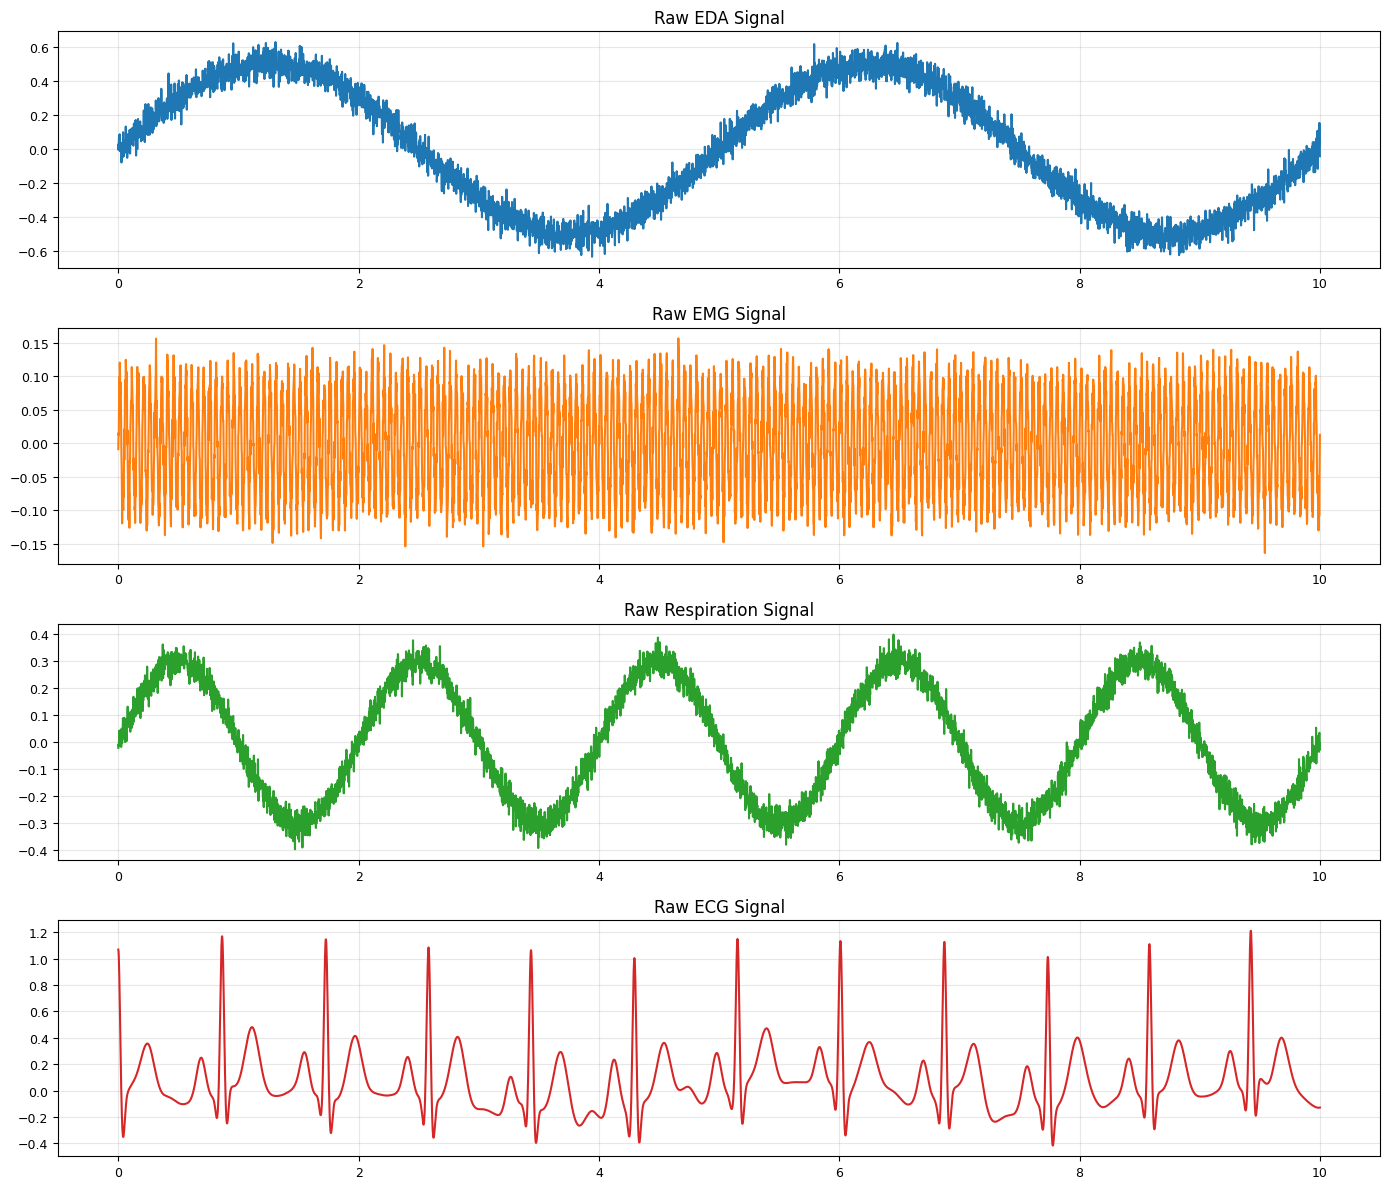

In [3]:
plt.figure(figsize=(14, 12))

plt.subplot(4, 1, 1)
plt.plot(t, eda, color='tab:blue')
plt.title('Raw EDA Signal')

plt.subplot(4, 1, 2)
plt.plot(t, emg, color='tab:orange')
plt.title('Raw EMG Signal')

plt.subplot(4, 1, 3)
plt.plot(t, resp, color='tab:green')
plt.title('Raw Respiration Signal')

plt.subplot(4, 1, 4)
plt.plot(t, ecg, color='tab:red')
plt.title('Raw ECG Signal')

plt.tight_layout()
plt.show()

## 4. Deep Dive: Signal Validation & Handling Negative Strides

When processing signals, it is critical to ensure that the arrays are contiguous. Sometimes operations (like slicing in reverse) can lead to negative strides, which cause issues when converting arrays to PyTorch tensors. We demonstrate a robust validation function that ensures contiguity and prints array stride information for debugging.

In [9]:
def validate_signal(signal):
    """Ensure the signal is a contiguous NumPy array with positive strides."""
    if not isinstance(signal, np.ndarray):
        signal = np.array(signal)
    signal = np.ascontiguousarray(signal)
    return signal

def detect_artifacts(signal, threshold=3.0):
    """Detect artifacts in the signal using a robust z-score (MAD method)."""
    signal = validate_signal(signal)
    median_value = np.median(signal)
    mad = np.median(np.abs(signal - median_value))
    robust_z = np.abs((signal - median_value) / (mad + 1e-6))
    artifacts = robust_z > threshold
    return artifacts

def remove_artifacts(signal, threshold=3.0):
    """Replace detected artifacts with the signal's median value."""
    artifacts = detect_artifacts(signal, threshold)
    clean_signal = signal.copy()
    median_value = np.median(signal)
    clean_signal[artifacts] = median_value
    return clean_signal

# Demonstrate validation on a reversed slice (which produces negative strides)
example_signal = np.arange(10)[::-1]
print("Example signal (possibly negative strides):", example_signal)
print("Before validation - strides:", example_signal.strides)
validated_signal = validate_signal(example_signal)
print("After validation - strides:", validated_signal.strides)

Example signal (possibly negative strides): [9 8 7 6 5 4 3 2 1 0]
Before validation - strides: (-8,)
After validation - strides: (8,)


## 5. Advanced Filtering Techniques

We implement several filtering functions. Here are some technical details:

- **Low-pass Filter:** Removes high-frequency noise. The cutoff frequency is normalized by the Nyquist frequency (0.5 * fs).
- **Bandpass Filter:** Keeps signals within a specific frequency band. Tuning the order and selecting proper low/high cutoff frequencies are crucial.
- **Notch Filter:** Removes specific interference, such as power line noise at 50 or 60 Hz, using an IIR notch filter.

These functions use `scipy.signal.butter`, `filtfilt` (for zero-phase filtering), and `iirnotch`.

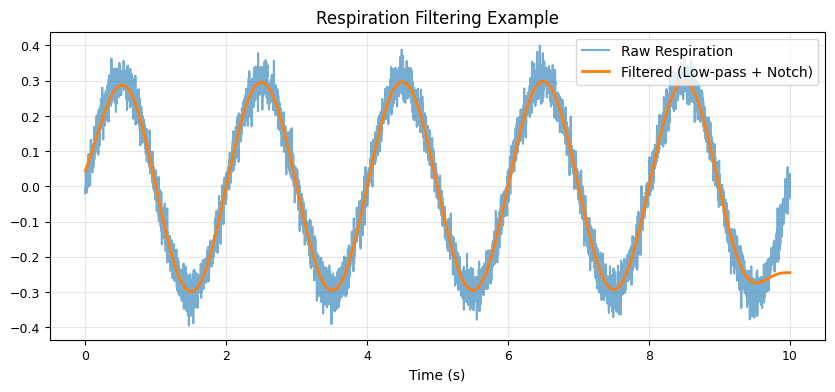

In [10]:
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def filter_signal(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    return filtfilt(b, a, data)

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, fs, freq=50.0, Q=30.0):
    """Apply a notch filter to remove a specific frequency."""
    nyquist = 0.5 * fs
    freq_norm = freq / nyquist
    b, a = iirnotch(freq_norm, Q)
    return filtfilt(b, a, data)

# Example: Filter the respiration signal
resp_low = filter_signal(resp, cutoff=1.0, fs=fs, order=3)
resp_filtered = notch_filter(resp_low, fs, freq=50.0, Q=30.0)

plt.figure(figsize=(10, 4))
plt.plot(t, resp, label='Raw Respiration', alpha=0.6)
plt.plot(t, resp_filtered, label='Filtered (Low-pass + Notch)', linewidth=2)
plt.title('Respiration Filtering Example')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

## 6. Advanced Denoising & Handling Negative Strides in Conversion

For signals like ECG, advanced denoising (e.g., wavelet thresholding) can significantly improve signal quality. However, when converting to a PyTorch tensor, negative strides can cause errors. We address this by ensuring contiguous arrays.

Below is the improved advanced denoising function.

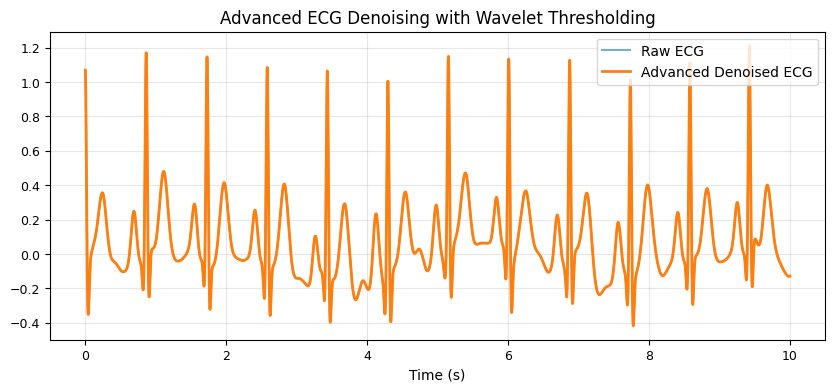

In [11]:
def advanced_ecg_denoising(ecg_signal):
    # Ensure the input is a contiguous array with positive strides
    ecg_signal_contig = np.ascontiguousarray(ecg_signal)
    ecg_tensor = torch.tensor(ecg_signal_contig, dtype=torch.float32)
    denoised_tensor = wavelet_denoise(ecg_tensor)
    return denoised_tensor.cpu().numpy()

# Apply advanced denoising to the ECG signal
ecg_advanced = advanced_ecg_denoising(ecg)

plt.figure(figsize=(10, 4))
plt.plot(t, ecg, label='Raw ECG', alpha=0.6)
plt.plot(t, ecg_advanced, label='Advanced Denoised ECG', linewidth=2)
plt.title('Advanced ECG Denoising with Wavelet Thresholding')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

## 7. Normalization & Segmentation: Edge Cases and Robust Strategies

Normalization (e.g. zero mean, unit variance) helps improve further analysis. Segmentation is used to break continuous signals into fixed-length chunks with optional overlap. Here we add error handling for cases where the segment length might not perfectly divide the signal length.

Below are our helper functions.

In [12]:
def normalize_signal(signal):
    """Standardize signal to zero mean and unit variance."""
    signal = validate_signal(signal)
    mean = np.mean(signal)
    std = np.std(signal) + 1e-6
    return (signal - mean) / std

def segment_signal(signal, segment_length, overlap=0.0):
    """Segment the signal into fixed-length chunks with an optional overlap (0.0 to 1.0)."""
    signal = validate_signal(signal)
    step = int(segment_length * (1 - overlap))
    segments = []
    for start in range(0, len(signal) - segment_length + 1, step):
        segments.append(signal[start:start + segment_length])
    segments = np.array(segments)
    if segments.size == 0:
        raise ValueError("No segments could be created. Check the segment length and overlap.")
    return segments

# Normalize and segment the advanced denoised ECG signal
ecg_norm = normalize_signal(ecg_advanced)
segments = segment_signal(ecg_norm, segment_length=fs*2, overlap=0.5)  # 2-second segments with 50% overlap
print("Segments shape:", segments.shape)

Segments shape: (9, 1000)


## 8. ComprehensivePreprocessor Class: A Modular Design

Now we integrate all the steps into a modular class. This class enables:

- Signal validation and artifact removal
- Application of multiple filter types
- Advanced denoising and normalization
- Segmentation of the processed signal

The class also prints debug information at key steps to help trace issues.

In [13]:
class ComprehensivePreprocessor:
    def __init__(self, fs=500):
        self.fs = fs
    
    def validate(self, signal):
        print("Validating signal...")
        return validate_signal(signal)
    
    def remove_artifacts(self, signal, threshold=3.0):
        print("Removing artifacts using MAD threshold:", threshold)
        return remove_artifacts(signal, threshold)
    
    def apply_lowpass(self, signal, cutoff, order=3):
        print(f"Applying low-pass filter with cutoff {cutoff} Hz, order {order}")
        return filter_signal(signal, cutoff, self.fs, order=order)
    
    def apply_bandpass(self, signal, lowcut, highcut, order=4):
        print(f"Applying bandpass filter with lowcut {lowcut} Hz and highcut {highcut} Hz")
        return bandpass_filter(signal, lowcut, highcut, self.fs, order=order)
    
    def apply_notch(self, signal, freq=50.0, Q=30.0):
        print(f"Applying notch filter at {freq} Hz with Q={Q}")
        return notch_filter(signal, self.fs, freq=freq, Q=Q)
    
    def advanced_denoise(self, signal):
        print("Performing advanced ECG denoising...")
        return advanced_ecg_denoising(signal)
    
    def normalize(self, signal):
        print("Normalizing signal...")
        return normalize_signal(signal)
    
    def segment(self, signal, segment_length, overlap=0.0):
        print(f"Segmenting signal with segment_length={segment_length} and overlap={overlap}")
        return segment_signal(signal, segment_length, overlap)
    
    def preprocess_ecg(self, ecg_signal):
        print("Starting full ECG preprocessing...")
        sig = self.validate(ecg_signal)
        sig = self.remove_artifacts(sig)
        sig = self.apply_lowpass(sig, cutoff=40)  # remove high-frequency noise
        sig = self.advanced_denoise(sig)  # run advanced denoising
        sig = self.normalize(sig)
        return sig
    
    def preprocess_signal(self, signal, filter_type='lowpass', **kwargs):
        print(f"Preprocessing signal with filter type: {filter_type}")
        sig = self.validate(signal)
        sig = self.remove_artifacts(sig)
        if filter_type == 'lowpass':
            cutoff = kwargs.get('cutoff', 1.0)
            sig = self.apply_lowpass(sig, cutoff=cutoff)
        elif filter_type == 'bandpass':
            lowcut = kwargs.get('lowcut', 20)
            highcut = kwargs.get('highcut', 150)
            sig = self.apply_bandpass(sig, lowcut=lowcut, highcut=highcut)
        sig = self.normalize(sig)
        return sig

# Instantiate the comprehensive preprocessor
preprocessor = ComprehensivePreprocessor(fs=fs)

# Process the simulated ECG through the full pipeline
ecg_processed = preprocessor.preprocess_ecg(ecg)

# Segment the processed ECG into 2-second segments with 50% overlap
ecg_segments = preprocessor.segment(ecg_processed, segment_length=fs*2, overlap=0.5)

print("Processed ECG shape:", ecg_processed.shape)
print("ECG Segments shape:", ecg_segments.shape)

Starting full ECG preprocessing...
Validating signal...
Removing artifacts using MAD threshold: 3.0
Applying low-pass filter with cutoff 40 Hz, order 3
Performing advanced ECG denoising...
Normalizing signal...
Segmenting signal with segment_length=1000 and overlap=0.5
Processed ECG shape: (5000,)
ECG Segments shape: (9, 1000)


## 9. Integration into Machine Learning and Deep Learning Pipelines

After preprocessing, we extract features from each segment and demonstrate integration into:

- **A Traditional ML Pipeline:** Using scikit-learn’s RandomForestClassifier
- **A Deep Learning Pipeline:** Using a simple PyTorch neural network

We extract basic statistical features (mean, standard deviation, min, max) from each segment.

In [14]:
def extract_features(signal_segment):
    features = {}
    features['mean'] = np.mean(signal_segment)
    features['std'] = np.std(signal_segment)
    features['min'] = np.min(signal_segment)
    features['max'] = np.max(signal_segment)
    return features

feature_list = []
for seg in ecg_segments:
    feats = extract_features(seg)
    feature_list.append([feats['mean'], feats['std'], feats['min'], feats['max']])

X_features = np.array(feature_list)
print("Feature matrix shape:", X_features.shape)

Feature matrix shape: (9, 4)


In [15]:
# --- Traditional Machine Learning Pipeline ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# For demonstration, synthesize binary labels based on a rule on the feature (e.g. mean < 0 -> 0; else 1)
y_labels = np.array([0 if feat[0] < 0 else 1 for feat in X_features])

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
ml_acc = accuracy_score(y_test, y_pred)

print("Random Forest Accuracy:", ml_acc)

Random Forest Accuracy: 1.0


In [16]:
# --- Deep Learning Pipeline with PyTorch ---
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class ECGFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ECGFeatureDataset(X_features, y_labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_dim = 4
hidden_dim = 16
num_classes = 2
model = SimpleMLP(input_dim, hidden_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score
dl_acc = accuracy_score(all_labels, all_preds)
print("Deep Learning Model Accuracy:", dl_acc)

Epoch 1/20, Loss: 0.6914
Epoch 2/20, Loss: 0.6907
Epoch 3/20, Loss: 0.6901
Epoch 4/20, Loss: 0.6895
Epoch 5/20, Loss: 0.6889
Epoch 6/20, Loss: 0.6883
Epoch 7/20, Loss: 0.6877
Epoch 8/20, Loss: 0.6872
Epoch 9/20, Loss: 0.6866
Epoch 10/20, Loss: 0.6861
Epoch 11/20, Loss: 0.6855
Epoch 12/20, Loss: 0.6850
Epoch 13/20, Loss: 0.6845
Epoch 14/20, Loss: 0.6840
Epoch 15/20, Loss: 0.6835
Epoch 16/20, Loss: 0.6829
Epoch 17/20, Loss: 0.6824
Epoch 18/20, Loss: 0.6819
Epoch 19/20, Loss: 0.6814
Epoch 20/20, Loss: 0.6809
Deep Learning Model Accuracy: 0.5


## 10. Advanced Debugging and Profiling Tips

For real-world applications, you may need to profile both memory usage and performance. Some tips include:

- **Array Strides and Memory:** Always convert non‐contiguous arrays with `np.ascontiguousarray` before tensor conversion.
- **Intermediate Checks:** Print shapes, strides, and intermediate results to verify that each step is working as expected.
- **Profiling:** Use tools like `%timeit` for execution time and packages such as `memory_profiler` to track memory usage.

Below is an example of checking an intermediate result:

In [ ]:
# Example of profiling an operation using %timeit
%timeit normalize_signal(ecg_advanced)

# Print memory usage of a NumPy array (requires memory_profiler package)
try:
    from memory_profiler import memory_usage
    mem_usage = memory_usage((np.mean, (ecg_advanced,)))
    print(f"Approximate memory usage for computing mean: {max(mem_usage)} MB")
except ImportError:
    print("Install memory_profiler to track memory usage.")

## Conclusion and Next Steps

In this deep dive we:

- Simulated various biosignals and visualized them.
- Addressed common technical pitfalls such as negative strides during tensor conversion and non‐contiguous arrays.
- Built robust filtering, artifact removal, advanced denoising, normalization, and segmentation functions.
- Integrated all steps into a modular preprocessing class complete with inline debugging outputs.
- Demonstrated integration with both traditional ML and DL pipelines with detailed profiling tips.

This notebook is meant to serve as a blueprint for building a production-level biosignal processing framework. As next steps, consider:

- Adding more advanced artifact detection algorithms
- Incorporating domain-specific feature extraction and classification models
- Using unit tests and continuous integration to validate the entire pipeline

Happy coding and deep diving!

## Creating the Dataset
A common approach is to use a sliding window over your ECG time series. For example, if you set a window length of 5 seconds (given a sampling rate of 500 Hz, that’s 2500 samples), the model will use these samples as input and try to predict an outcome for a future time period.

Here’s a conceptual outline (in Python with PyTorch) to generate your dataset:

Using device: cpu


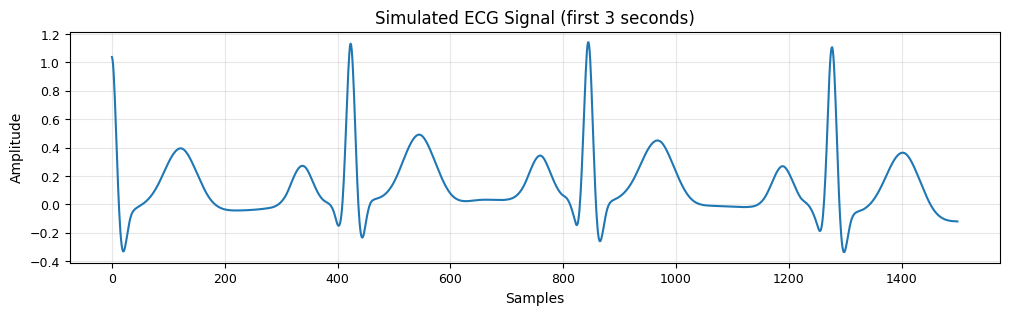

ECGForecastLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=250, bias=True)
)
Epoch 1/10 Loss: 0.046875
Epoch 2/10 Loss: 0.025148
Epoch 3/10 Loss: 0.015330
Epoch 4/10 Loss: 0.029525
Epoch 5/10 Loss: 0.029532
Epoch 6/10 Loss: 0.012001
Epoch 7/10 Loss: 0.007412
Epoch 8/10 Loss: 0.006224
Epoch 9/10 Loss: 0.005585
Epoch 10/10 Loss: 0.005316


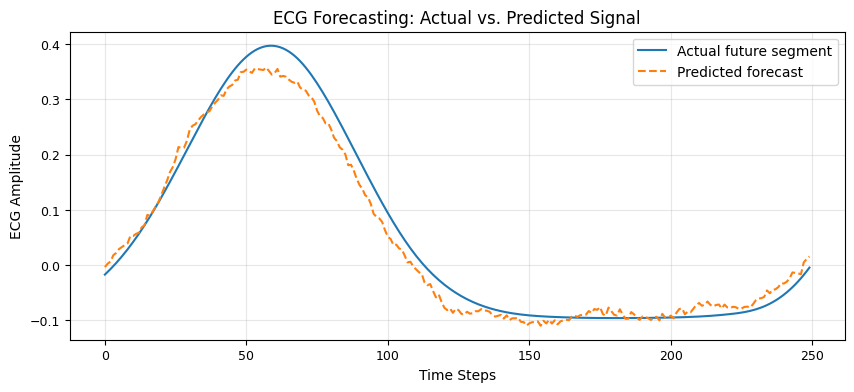

In [22]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

####################################
# 1. Simulate an ECG signal
####################################
# Define simulation parameters
fs = 500       # sampling frequency (Hz)
duration = 30  # duration in seconds
ecg_signal = nk.ecg_simulate(duration=duration, sampling_rate=fs, noise=0.05)
ecg_signal = np.array(ecg_signal)  # ensure it's a NumPy array

# Plot a segment of the simulated ECG
plt.figure(figsize=(12, 3))
plt.plot(ecg_signal[:1500])
plt.title("Simulated ECG Signal (first 3 seconds)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

####################################
# 2. Create a forecasting dataset
####################################
class ECGForecastDataset(Dataset):
    def __init__(self, ecg_signal, window_size, forecast_horizon):
        """
        ecg_signal: 1D numpy array of ECG data.
        window_size: number of past samples used as input.
        forecast_horizon: number of future samples to predict.
        """
        self.ecg_signal = ecg_signal
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        # Calculate the number of samples (each sample is a sliding window)
        self.n_samples = len(ecg_signal) - window_size - forecast_horizon + 1

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Input window
        X = self.ecg_signal[idx : idx + self.window_size]
        # Future segment to forecast
        y = self.ecg_signal[idx + self.window_size : idx + self.window_size + self.forecast_horizon]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define window and forecast lengths (in number of samples)
window_size = 500        # e.g., past 1 second at 500Hz
forecast_horizon = 250     # predict next 0.5 second

# Create the dataset and a corresponding DataLoader
dataset = ECGForecastDataset(ecg_signal, window_size, forecast_horizon)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

####################################
# 3. Define the LSTM Forecast Model
####################################
class ECGForecastLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, forecast_horizon=250):
        """
        input_size: number of input features per time step (1 for a single ECG value)
        hidden_size: number of features in the hidden state
        num_layers: number of stacked LSTM layers
        forecast_horizon: number of future samples to predict
        """
        super(ECGForecastLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM expects inputs as (batch, sequence, features)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer to map the last LSTM hidden state to the forecast output
        self.fc = nn.Linear(hidden_size, forecast_horizon)

    def forward(self, x):
        # x shape: (batch, seq_length)
        # Add an extra dimension for input_size (which is 1)
        x = x.unsqueeze(-1)  # now shape: (batch, seq_length, 1)
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Pass through LSTM layers
        out, _ = self.lstm(x, (h0, c0))
        # Get the last hidden state: shape (batch, hidden_size)
        last_hidden = out[:, -1, :]
        # Map the last hidden state to the forecast output: shape (batch, forecast_horizon)
        forecast = self.fc(last_hidden)
        return forecast

# Instantiate the model and move it to the chosen device
model = ECGForecastLSTM(input_size=1, hidden_size=64, num_layers=2, forecast_horizon=forecast_horizon).to(device)
print(model)

####################################
# 4. Train the Model
####################################
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in dataloader:
        # Move batch data to device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        # Forward pass: predict the future window from X_batch
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X_batch.size(0)

    epoch_loss /= len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.6f}")

####################################
# 5. Evaluate the Model
####################################
# Switch to evaluation mode
model.eval()

# Select a random index to visualize the forecast performance
sample_idx = np.random.randint(0, len(dataset))
X_sample, y_true = dataset[sample_idx]
X_sample = X_sample.unsqueeze(0).to(device)  # add batch dimension and move to device

# Generate a prediction
with torch.no_grad():
    y_pred = model(X_sample)
y_pred = y_pred.squeeze().cpu().numpy()  # remove batch dim and move to CPU
y_true = y_true.numpy()

# Plot true future segment vs. predicted forecast
plt.figure(figsize=(10, 4))
plt.plot(y_true, label="Actual future segment")
plt.plot(y_pred, label="Predicted forecast", linestyle="--")
plt.title("ECG Forecasting: Actual vs. Predicted Signal")
plt.xlabel("Time Steps")
plt.ylabel("ECG Amplitude")
plt.legend()
plt.show()

Using device: mps


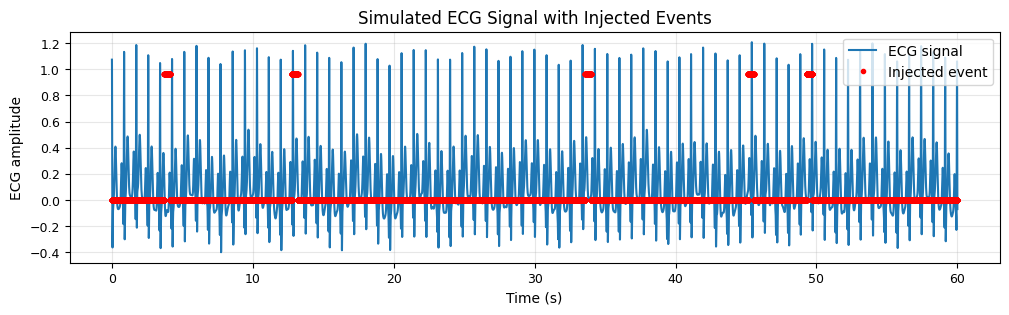

Dataset size: 28001

Training model: LSTMClassifier


/Users/linh/Downloads/ECGPreprocessor/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10: Train Loss 0.5188, Train Acc 0.7864 | Val Loss 0.5083, Val Acc 0.7940
Epoch 2/10: Train Loss 0.5143, Train Acc 0.7901 | Val Loss 0.5097, Val Acc 0.7940
Epoch 3/10: Train Loss 0.5143, Train Acc 0.7901 | Val Loss 0.5081, Val Acc 0.7940
Epoch 4/10: Train Loss 0.5140, Train Acc 0.7901 | Val Loss 0.5079, Val Acc 0.7940
Epoch 5/10: Train Loss 0.5141, Train Acc 0.7901 | Val Loss 0.5082, Val Acc 0.7940
Epoch 6/10: Train Loss 0.5141, Train Acc 0.7901 | Val Loss 0.5078, Val Acc 0.7940
Epoch 7/10: Train Loss 0.5140, Train Acc 0.7901 | Val Loss 0.5078, Val Acc 0.7940
Epoch 8/10: Train Loss 0.5137, Train Acc 0.7901 | Val Loss 0.5077, Val Acc 0.7940
Epoch 9/10: Train Loss 0.5138, Train Acc 0.7901 | Val Loss 0.5088, Val Acc 0.7940
Epoch 10/10: Train Loss 0.5140, Train Acc 0.7901 | Val Loss 0.5077, Val Acc 0.7940
Final Validation Accuracy for LSTMClassifier: 0.7940

Training model: TCNClassifier
Epoch 1/10: Train Loss 0.5130, Train Acc 0.7901 | Val Loss 0.5076, Val Acc 0.7940
Epoch 2/10: T

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Choose device: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("Using device:", device)

####################################
# 1. Simulate ECG Signal and Inject Events
####################################
# Parameters for simulation
fs = 500                   # Sampling frequency (Hz)
duration = 60              # Duration in seconds (total samples = fs * duration)
ecg_signal = nk.ecg_simulate(duration=duration, sampling_rate=fs, noise=0.05)
ecg_signal = np.array(ecg_signal)   # Ensure it's a NumPy array
signal_length = len(ecg_signal)

# Define window length and forecast horizon (in samples)
window_size = 1000         # Use past 2 seconds (if fs=500, 1000 samples)
forecast_horizon = 1000    # Look 2 seconds ahead for an upcoming event

# Create a synthetic event indicator array.
# We "inject" a few events into the ECG. In practice, these come from labels.
event_indicator = np.zeros(signal_length)
num_events = 5             # Number of events to inject
event_duration = 200       # Duration (in samples) that an event lasts

for i in range(num_events):
    # Choose a random start time ensuring there's room for the forecast window.
    event_start = np.random.randint(window_size, signal_length - forecast_horizon - event_duration)
    event_indicator[event_start:event_start + event_duration] = 1

# For visualization, plot a short segment of ECG and overlay event regions
plt.figure(figsize=(12, 3))
time_axis = np.arange(signal_length) / fs
plt.plot(time_axis, ecg_signal, label="ECG signal")
plt.plot(time_axis, event_indicator * (np.max(ecg_signal) * 0.8), 'r.', label="Injected event")
plt.xlabel("Time (s)")
plt.ylabel("ECG amplitude")
plt.title("Simulated ECG Signal with Injected Events")
plt.legend()
plt.show()

####################################
# 2. Create Dataset for Event Prediction
####################################
class ECGEventDataset(Dataset):
    """
    This dataset creates a sliding window of past ECG samples and assigns a binary label.
    The label is 1 if any event is present in the forecast horizon immediately following the window,
    and 0 otherwise.
    """
    def __init__(self, ecg_signal, event_indicator, window_size, forecast_horizon):
        self.ecg_signal = ecg_signal
        self.event_indicator = event_indicator
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        self.n_samples = len(ecg_signal) - window_size - forecast_horizon + 1

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Input: past window of ECG samples
        X = self.ecg_signal[idx: idx + self.window_size]
        # Label: 1 if any event is present in the forecast horizon, else 0
        label = 1.0 if np.any(self.event_indicator[idx + self.window_size: idx + self.window_size + self.forecast_horizon]) else 0.0
        return torch.tensor(X, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# Instantiate the dataset
dataset = ECGEventDataset(ecg_signal, event_indicator, window_size, forecast_horizon)
print("Dataset size:", len(dataset))

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

####################################
# 3. Define Models for Event Detection
####################################

# 3.1 LSTM Classifier
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM expects input shape (batch, seq_len, features)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch, window_size)
        x = x.unsqueeze(-1)  # (batch, window_size, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        last_hidden = out[:, -1, :]   # last time step hidden state
        logit = self.fc(last_hidden)
        return torch.sigmoid(logit).squeeze(-1)

# 3.2 TCN Classifier (using dilated convolutions)
class TCNClassifier(nn.Module):
    def __init__(self, num_channels=32, num_levels=3):
        super(TCNClassifier, self).__init__()
        layers = []
        in_channels = 1  # input signal channel
        kernel_size = 3
        for i in range(num_levels):
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation  # to keep output length same as input
            layers.append(nn.Conv1d(in_channels,
                                    num_channels,
                                    kernel_size,
                                    padding=padding,
                                    dilation=dilation))
            layers.append(nn.ReLU())
            in_channels = num_channels
        self.network = nn.Sequential(*layers)
        # Global average pooling followed by a fully connected layer for binary classification
        self.fc = nn.Linear(num_channels, 1)

    def forward(self, x):
        # x: (batch, window_size)
        x = x.unsqueeze(1)  # (batch, 1, window_size)
        out = self.network(x)  # (batch, num_channels, L)
        out = out[:, :, :x.size(2)]  # trim to original length if needed (due to padding)
        # Global average pooling over time dimension
        out = out.mean(dim=2)  # (batch, num_channels)
        logit = self.fc(out)
        return torch.sigmoid(logit).squeeze(-1)

# 3.3 Transformer Classifier
class TransformerClassifier(nn.Module):
    def __init__(self, window_size, d_model=64, nhead=8, num_layers=2):
        super(TransformerClassifier, self).__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (batch, window_size)
        x = x.unsqueeze(-1)  # (batch, window_size, 1)
        x = self.input_proj(x)  # (batch, window_size, d_model)
        # Transformer expects shape (seq_len, batch, d_model)
        x = x.transpose(0, 1)  # (window_size, batch, d_model)
        transformer_out = self.transformer_encoder(x)  # (window_size, batch, d_model)
        # Take the mean over the sequence dimension
        pool = transformer_out.mean(dim=0)  # (batch, d_model)
        logit = self.fc(pool)
        return torch.sigmoid(logit).squeeze(-1)

# 3.4 Hybrid Model: CNN + LSTM Classifier
class HybridCNNLSTMClassifier(nn.Module):
    def __init__(self, window_size, cnn_channels=16, hidden_size=32, num_layers=1):
        super(HybridCNNLSTMClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, cnn_channels, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)  # reduces length by factor 2
        # LSTM takes in sequence features from CNN (cnn_channels features per time step)
        self.lstm = nn.LSTM(cnn_channels, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, window_size)
        x = x.unsqueeze(1)   # (batch, 1, window_size)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)      # (batch, cnn_channels, window_size/2)
        x = x.transpose(1, 2) # (batch, window_size/2, cnn_channels)
        lstm_out, (hn, _) = self.lstm(x)  # (batch, seq_len, hidden_size)
        logit = self.fc(hn[-1])           # use the last hidden state
        return torch.sigmoid(logit).squeeze(-1)

# 3.5. Hybrid Model: Transformer + LSTM Classifier
class HybridTransformerLSTMClassifier(nn.Module):
    def __init__(self, window_size, d_model=64, nhead=8, transformer_layers=2,
                 lstm_hidden_size=32, lstm_layers=1, dropout=0.1):
        """
        Parameters:
          window_size (int): Number of time steps in the input sequence.
          d_model (int): Dimension of the input projection and Transformer features.
          nhead (int): Number of heads in the Transformer encoder.
          transformer_layers (int): Number of stacked Transformer encoder layers.
          lstm_hidden_size (int): Number of features in the LSTM hidden state.
          lstm_layers (int): Number of stacked LSTM layers.
          dropout (float): Dropout probability.
        """
        super(HybridTransformerLSTMClassifier, self).__init__()

        # Input projection: map the one-dimensional input into a d_model-dimensional space.
        self.input_proj = nn.Linear(1, d_model)

        # Transformer encoder layers.
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        # LSTM to further capture sequential dynamics.
        self.lstm = nn.LSTM(input_size=d_model,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_layers,
                            batch_first=True)

        # Fully-connected output: maps the LSTM's last hidden state to a probability.
        self.fc = nn.Linear(lstm_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Input:
            x: Tensor of shape (batch_size, window_size)
        Output:
            prob: Tensor of shape (batch_size) representing the predicted probability.
        """
        # x shape: (batch_size, window_size)
        # Unsqueeze to (batch_size, window_size, 1) since we have one feature (ECG value).
        x = x.unsqueeze(-1)
        # Project input to d_model dimension.
        x = self.input_proj(x)  # now shape: (batch_size, window_size, d_model)

        # Transformer expects input shape (sequence_length, batch_size, d_model).
        x = x.transpose(0, 1)  # (window_size, batch_size, d_model)
        x = self.transformer_encoder(x)  # Output shape remains (window_size, batch_size, d_model)

        # Convert back to shape (batch_size, window_size, d_model).
        x = x.transpose(0, 1)

        # Pass through LSTM.
        lstm_out, (hn, cn) = self.lstm(x)  # lstm_out: (batch_size, window_size, lstm_hidden_size)
        # Use the last hidden state of the last LSTM layer as the representation.
        last_hidden = hn[-1]  # (batch_size, lstm_hidden_size)

        # Fully connected layer to predict the event probability.
        logits = self.fc(last_hidden)  # (batch_size, 1)
        prob = self.sigmoid(logits).squeeze(-1)  # (batch_size)
        return prob

####################################
# 4. Training and Evaluation Functions
####################################
def train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).float()
            train_correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss /= total
        train_acc = train_correct / total

        # Evaluation on validation set
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
                preds = (outputs >= 0.5).float()
                val_correct += (preds == y_val).sum().item()
                total_val += y_val.size(0)
        val_loss /= total_val
        val_acc = val_correct / total_val

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")
    return model

####################################
# 5. Instantiate, Train, and Evaluate Each Model
####################################
num_epochs = 10  # For demonstration; adjust as necessary
learning_rate = 0.001

# Dictionary to hold models and their names for iteration.
model_dict = {
    # "LSTMClassifier": LSTMClassifier(),
    # "TCNClassifier": TCNClassifier(),
    # "TransformerClassifier": TransformerClassifier(window_size=window_size),
    "HybridCNNLSTMClassifier": HybridCNNLSTMClassifier(window_size=window_size),
    "HybridTransformerLSTMClassifier": HybridTransformerLSTMClassifier(window_size=window_size)
}

# Iterate through each model type, train, and evaluate.
for model_name, model in model_dict.items():
    print("\nTraining model:", model_name)
    model = model.to(device)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss since output is probability
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Final evaluation
    model.eval()
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            preds = (outputs >= 0.5).float()
            val_correct += (preds == y_val).sum().item()
            total_val += y_val.size(0)
    val_acc = val_correct / total_val
    print(f"Final Validation Accuracy for {model_name}: {val_acc:.4f}")

## GNN-Only Model for Cardiac Event Prediction
In many scenarios, you may represent your ECG data (or features extracted per heartbeat) as a graph. For example, each heart beat can be a node (with features such as morphology, timing, or HRV metrics) with edges connecting neighboring beats (or beats exhibiting similar characteristics). The following model uses two graph convolution layers (GCNConv) and a global pooling operation to produce a graph-level prediction (e.g., the probability of a future cardiac event):

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GNNClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        """
        in_channels (int): Number of features per node.
        hidden_channels (int): Dimension of hidden representations.
        num_classes (int): Number of output classes (use 1 for binary classification with a sigmoid).
        """
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # A fully connected layer to produce graph-level output.
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        """
        x: Node feature matrix of shape (num_nodes, in_channels).
        edge_index: Graph connectivity (COO format) tensor.
        batch: Batch vector which assigns each node to a specific example in the batch.
        """
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        # Aggregate nodes into a graph-level representation.
        x = global_mean_pool(x, batch)  # shape: (batch_size, hidden_channels)
        out = self.fc(x)
        return torch.sigmoid(out).squeeze(-1)

# Example usage with dummy data:
if __name__ == '__main__':
    # Suppose we have a graph with 100 nodes, each with 10 features.
    num_nodes = 100
    in_channels = 10
    hidden_channels = 32
    num_classes = 1  # binary classification

    # Dummy node features.
    x = torch.randn((num_nodes, in_channels))
    # Dummy edge_index (example connectivity)
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    # Suppose we have 5 graphs in the batch, and nodes are assigned to graphs randomly.
    batch = torch.randint(0, 5, (num_nodes,))

    model = GNNClassifier(in_channels, hidden_channels, num_classes)
    output = model(x, edge_index, batch)
    print("GNN model output shape:", output.shape)  # Expected: (batch_size,)

## Hybrid GNN + LSTM Model (Graph-Sequential)
There are situations where you might want to capture not only the local relationships of beats (via a GNN) but also the sequential evolution of these relationships over time. For example, if you extract features per beat and then order these beats by time, you can treat each graph as a sequence. In the following hybrid model, we first use the GNN to obtain node (beat) embeddings and then feed the ordered embeddings into an LSTM for sequential modeling.

Assumption: Here we assume that—within each graph (or patient record)—the nodes are ordered by time. In practice, you might build or sort the nodes such that the ordering corresponds to the temporal sequence (and pad sequences if necessary).

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class HybridGNNLSTMClassifier(torch.nn.Module):
    def __init__(self, in_channels, gnn_hidden_channels, lstm_hidden_size, lstm_layers, num_classes):
        """
        in_channels (int): Number of input features per node.
        gnn_hidden_channels (int): Hidden dimension for the GNN layers.
        lstm_hidden_size (int): Hidden dimension for the LSTM.
        lstm_layers (int): Number of LSTM layers.
        num_classes (int): Number of output classes (1 for binary classification).
        """
        super(HybridGNNLSTMClassifier, self).__init__()
        # Two GCN layers to get node embeddings.
        self.conv1 = GCNConv(in_channels, gnn_hidden_channels)
        self.conv2 = GCNConv(gnn_hidden_channels, gnn_hidden_channels)

        # LSTM to capture the temporal evolution of node embeddings.
        self.lstm = nn.LSTM(
            input_size=gnn_hidden_channels,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True
        )
        # A fully-connected layer from the LSTM's last hidden state to output.
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x, edge_index, batch):
        """
        x: Node feature matrix (num_nodes, in_channels).
        edge_index: Graph connectivity.
        batch: Batch vector assigning nodes to graphs.

        This model assumes that for each graph in the batch, the nodes are in the temporal order.
        It also assumes that each graph has the same number of nodes (or sequences are padded appropriately).
        """
        # Apply GNN layers.
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        # Rearrange node embeddings into sequences per graph.
        batch_size = int(batch.max().item()) + 1
        node_counts = torch.bincount(batch)
        # For simplicity assume each graph has the same number of nodes, T.
        T = node_counts[0].item()  # e.g., number of beats per record
        # It is important that nodes for each graph are ordered by time.
        # Here, we assume nodes in x are sorted appropriately according to `batch`.
        x = x.view(batch_size, T, -1)  # Shape: (batch_size, T, gnn_hidden_channels)

        # Process the sequence with LSTM.
        lstm_out, (hn, _) = self.lstm(x)
        # Use the last hidden state of the LSTM as a sequence representation.
        last_hidden = hn[-1]  # Shape: (batch_size, lstm_hidden_size)
        out = self.fc(last_hidden)
        return torch.sigmoid(out).squeeze(-1)

# Example usage for the hybrid model:
if __name__ == '__main__':
    # Assume 100 nodes overall with each graph having 20 nodes, and there are 5 graphs in the batch.
    num_nodes = 100
    in_channels = 10
    gnn_hidden_channels = 32
    lstm_hidden_size = 16
    lstm_layers = 1
    num_classes = 1

    # Dummy node features.
    x = torch.randn((num_nodes, in_channels))
    # Dummy edge_index for connectivity (this example uses random graph connections).
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    # Create batch assignment: suppose 5 graphs, each with 20 nodes.
    batch = torch.cat([torch.full((20,), i) for i in range(5)], dim=0)

    model = HybridGNNLSTMClassifier(in_channels, gnn_hidden_channels, lstm_hidden_size, lstm_layers, num_classes)
    output = model(x, edge_index, batch)
    print("Hybrid model output shape:", output.shape)  # Expected: (batch_size,) which is (5,)

21.2 μs ± 71.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Install memory_profiler to track memory usage.


## Discussion
### GNN-Only Models:
GNNs can be particularly effective when the data naturally form a graph structure—for example, when the relationships or similarity between heartbeats (or between different sensor signals) is important for predicting an event. Models like GCNs, Graph Attention Networks (GATs), or even more advanced architectures can capture such relations.
### Hybrid GNN + Sequential Models:
In some cases, you not only want to capture relationships using a graph but also wish to explicitly model temporal evolution. The hybrid approach first uses a GNN to obtain embeddings from relational structures (e.g., per-beat features) and then uses a sequential model (e.g., LSTM or Transformer) to learn temporal dependencies across these events. This combination can capture both the structural and temporal complexities underlying the prediction of heart failure or other cardiac events.
### When to Use Each:
- Use a pure GNN if your data’s key information is contained in the pairwise relationships or network structure between features, beats, or sensors.
- Use a hybrid approach if you have time-ordered events (e.g., sequential beats, multi-modal time series) and you want to benefit from both relational (graph) and sequential (LSTM/Transformer) modeling.

Both paradigms are under active research for biomedical applications, and combining them can yield improved performance on complex prediction tasks.

If you have further questions or need additional modifications (for example, incorporating attention mechanisms or a Transformer instead of an LSTM), feel free to ask!